In [30]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import warnings #to remove the warnings
import random
import sys
sys.path.append('../../_hepers_')
from genNewVals import generateNewFeatureValMultiple
from subsampleData import subsample
from models import trainModels
from genFillNulls import *
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler





In [31]:
def trainF1CrossValModels(X, y, numFolds):
    nb = GaussianNB()
    nbScores = cross_val_score(nb, X, y, cv=numFolds, scoring='f1')
    print('Completed Naive Bayes')
    logisticClassifier = LogisticRegression()
    logScores = cross_val_score(logisticClassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed Logistic Regression')
    svclassifier = SVC(kernel='linear', max_iter = 5000000)
    svmScores = cross_val_score(svclassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed SVM')
    clf = DecisionTreeClassifier(random_state = 42)
    dtScrores = cross_val_score(clf, X, y, cv=numFolds, scoring='f1')
    print('Completed Decision Tree')
    votingCl = VotingClassifier(
                estimators =    [('gnb', GaussianNB()),
                                ('lr',  LogisticRegression()),
                                ('svm', SVC(kernel='linear', max_iter = 5000000)),
                                ('dtc', DecisionTreeClassifier(random_state=42))], 
                voting='hard')
    voteScores = cross_val_score(votingCl, X, y, cv=numFolds, scoring='f1')
    print('Completed Voting Classification')
    return nbScores, logScores, svmScores, dtScrores, voteScores

def generateSupplementalData(X_train, y_train, numBenign = 0, numMalig = 0):
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
    benignDF.columns, malignantDF.columns = trainingSet.columns, trainingSet.columns
    numBenignNeeded = numBenign - benignDF.shape[0]
    numMaligNeeded = numMalig - malignantDF.shape[0]

    #Storing all Raw Benign Data to Later be Merged with Synthetic
    preExistingBenign = []
    for index, row in benignDF.iterrows():
        preExistingBenign.append(list(row))
    preExistingBenign = np.array(preExistingBenign)
    
    #Storing all Raw Malignant Data to Later be Merged with Synthetic
    preExistingMalig = []
    for index, row in malignantDF.iterrows():
        preExistingMalig.append(list(row))
    preExistingMalig = np.array(preExistingMalig)

    #Generating New Data
    benignPatients = []
    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, numBenignNeeded))
    benignPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, numMaligNeeded))
    malignangPatients = np.array(malignangPatients).T

    #Combining Real Data and Synthetic Data, or Only using Real Data in the case of majority class
    if np.array(benignPatients).shape[0] > 0:
        benignPatients = np.vstack((preExistingBenign, np.array(benignPatients)))
    else:
        benignPatients = preExistingBenign
    if np.array(malignangPatients).shape[0] > 0:
        malignangPatients = np.vstack((preExistingMalig, np.array(malignangPatients)))
    else:
        benignPatients = preExistingBenign
    jointArray = np.vstack((benignPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns) 

    #Reporting Summary
    print('Final Dataset Composition: {}'.format(finalDataset.shape))
    print(' - Benign:')
    print('   -   New Benign Instances Created: {}'.format(numBenignNeeded))
    print('   -   Old Benign Instances Used: {}'.format(preExistingBenign.shape[0]))
    print(' - Malignant:')
    print('   -   New Malignant Instances Created: {}'.format(numMaligNeeded))
    print('   -   Old Malignant Instances Used: {}'.format(preExistingMalig.shape[0]))
    return finalDataset

def printOutputs(naiveBayesScore, LogScore, SVMScore, DTScore, VoteScore):
    print('NB Mean Scores: {}'.format(np.mean(naiveBayesScore)))
    print('LR Mean Scores: {}'.format(np.mean(LogScore)))
    print('SVM Mean Scores: {}'.format(np.mean(SVMScore)))
    print('DT Mean Scores: {}'.format(np.mean(DTScore)))
    print('VC Mean Scores: {}'.format(np.mean(VoteScore)))

In [32]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')

cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Biopsy']

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsRemoved = cervical_df.replace('?', np.nan)

cervicalAllNullsRemoved = cervicalAllNullsRemoved.dropna()
print(cervicalAllNullsRemoved.shape)
print(cervicalAllNullsRemoved.columns)

(59, 32)
Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
       'Biopsy'],
      dtype='object')


In [34]:
print(cervicalAllNullsRemoved.columns)
cervicalAllNullsRemoved.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
X = cervicalAllNullsRemoved[cervical_df.columns[:-4]]
y = cervicalAllNullsRemoved[cervical_df.columns[-1]]
print(X.shape)
print(y.shape)
nullNB, nullLog, nullSVM, nullDT, nullVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(nullNB)))
print('LR Mean Scores: {}'.format(np.mean(nullLog)))
print('SVM Mean Scores: {}'.format(np.mean(nullSVM)))
print('DT Mean Scores: {}'.format(np.mean(nullDT)))
print('VC Mean Scores: {}'.format(np.mean(nullVote)))

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
       'Diagnosis'],
      dtype='object')


KeyError: 'Biopsy'

In [35]:
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervical_df.columns[:-4]]
y = cervicalAllNullsSyntheticFilled[cervical_df.columns[-1]]
nullFillNB, nullFillLog, nullFillSVM, nullFillDT, nullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(nullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(nullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(nullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(nullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(nullFillVote)))


Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.12663721341640066
LR Mean Scores: 0.0
SVM Mean Scores: 0.0
DT Mean Scores: 0.14160985213616792
VC Mean Scores: 0.0


In [36]:
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)

X = cervicalAllNullsSyntheticFilled[cervical_df.columns[:-4]]
y = cervicalAllNullsSyntheticFilled[cervical_df.columns[-1]]
numClassSamples = len(y) - int(sum(y))

finalDataset = generateSupplementalData(X, y, numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[cervical_df.columns[:-4]]
y = finalDataset[cervical_df.columns[-1]]
balNullFillNB, balNullFillLog, balNullFillSVM, balNullFillDT, balNullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(balNullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(balNullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(balNullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(balNullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(balNullFillVote)))

Final Dataset Composition: (1606, 29)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 803
 - Malignant:
   -   New Malignant Instances Created: 748
   -   Old Malignant Instances Used: 55
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.6769148246431959
LR Mean Scores: 0.7304455192467423
SVM Mean Scores: 0.7224251522501184
DT Mean Scores: 0.9067798745401443
VC Mean Scores: 0.7853349249632223


0.10066666666666665
0.0
0.33666666666666667
[0.33666666666666667, 0.0, 0.1, 0.06666666666666667, 0.0]
0.7643800591286846
0.6769148246431959
0.9067798745401443
[0.6769148246431959, 0.7304455192467423, 0.7224251522501184, 0.9067798745401443, 0.7853349249632223]
----------
0.663713392462018


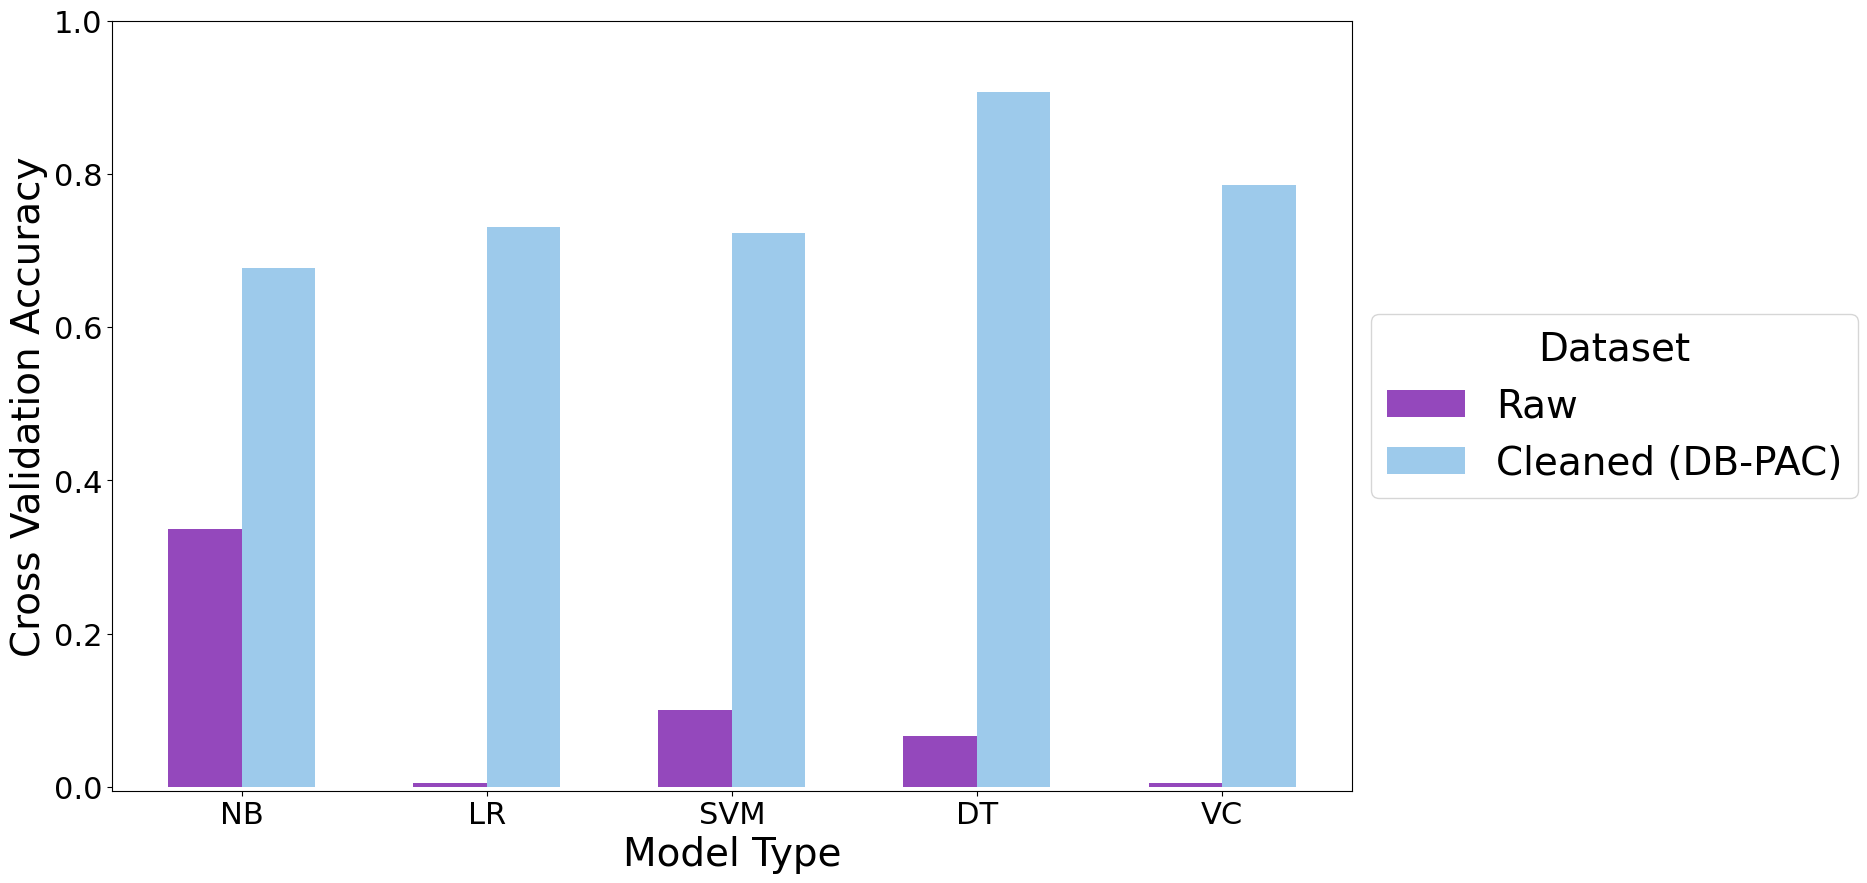

In [40]:
X = ['NB','LR','SVM', 'DT', 'VC' ]


nullLeft = [np.mean(nullNB), np.mean(nullLog), np.mean(nullSVM),
        np.mean(nullDT), np.mean(nullVote)]

print(np.mean(nullLeft))
print(min(nullLeft))
print(max(nullLeft))
print(nullLeft)

balNullFilled = [np.mean(balNullFillNB), np.mean(balNullFillLog), np.mean(balNullFillSVM),
        np.mean(balNullFillDT), np.mean(balNullFillVote)]


print(np.mean(balNullFilled))
print(min(balNullFilled))
print(max(balNullFilled))
print(balNullFilled)
print('-'*10)
print(np.mean(np.array(balNullFilled) - np.array(nullLeft)))

X_axis = np.arange(len(X))

for i in range(len(nullLeft)):
        if nullLeft[i] == 0:
                nullLeft[i] = 0.005

plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.bar(X_axis - 0.15, nullLeft, 0.3, label = 'Raw', color = '#9448BC')
plt.bar(X_axis + 0.15, balNullFilled, 0.3, label = 'Cleaned (DB-PAC)', color='#9DCAEB')
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(-0.005,1)
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0.7713989893340191
0.6744697235992763
0.914703404674923


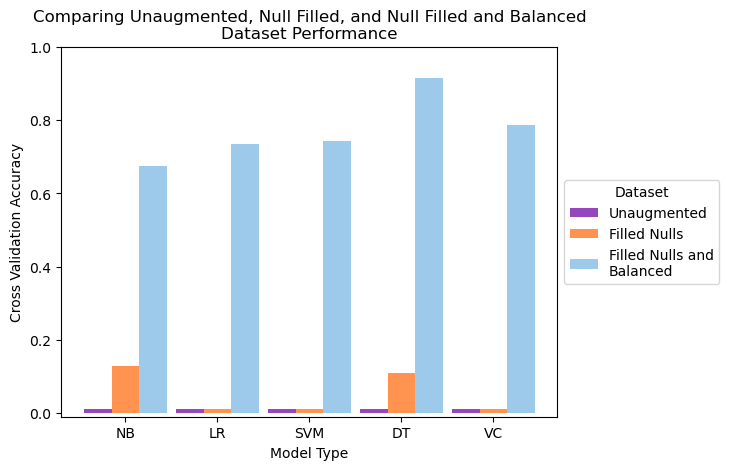

In [8]:
X = ['NB','LR','SVM', 'DT', 'VC' ]

nullFilled = [np.mean(nullFillNB), np.mean(nullFillLog), np.mean(nullFillSVM),
        np.mean(nullFillDT), np.mean(nullFillVote)]

for i in range(len(nullFilled)):
        if nullFilled[i] == 0:
                nullFilled[i] = 0.01


balNullFilled = [np.mean(balNullFillNB), np.mean(balNullFillLog), np.mean(balNullFillSVM),
        np.mean(balNullFillDT), np.mean(balNullFillVote)]
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.3, [0.01,0.01,0.01,0.01,0.01], 0.3, label = 'Unaugmented', color = '#9448BC')
plt.bar(X_axis - 0, nullFilled, 0.3, label = 'Filled Nulls', color='#FF934F')
plt.bar(X_axis + 0.3, balNullFilled, 0.3, label = 'Filled Nulls and\nBalanced', color='#9DCAEB')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(-0.01,1)
plt.title("Comparing Unaugmented, Null Filled, and Null Filled and Balanced\nDataset Performance")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')

cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Biopsy']

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsRemoved = removeEntriesWithNulls(cervical_df)
print(cervicalAllNullsRemoved.shape)


In [17]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
numClassSamples = int(max((len(y) - sum(y)), sum(y)))
finalDataset = generateSyntheticDataset(X, y,  identical = False, numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
print(X.shape)

balNullFillNB, balNullFillLog, balNullFillSVM, balNullFillDT, balNullFillVote = trainF1CrossValModels(X, y)

print('NB Mean Scores: {}'.format(np.mean(balNullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(balNullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(balNullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(balNullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(balNullFillVote)))


(1606, 28)


KeyboardInterrupt: 

In [5]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
nullFillNB, nullFillLog, nullFillSVM, nullFillDT, nullFillVote = trainF1CrossValModels(X, y)

print('NB Mean Scores: {}'.format(np.mean(nullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(nullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(nullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(nullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(nullFillVote)))


NB Mean Scores: 0.12710098620088256
LR Mean Scores: 0.0
SVM Mean Scores: 0.0
DT Mean Scores: 0.11200400476716266
VC Mean Scores: 0.0


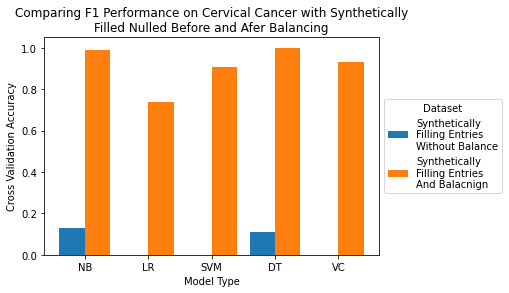

In [15]:
X_Vals = ['NB','LR','SVM', 'DT', 'VC' ]



bal = [np.mean(balNullFillNB), np.mean(balNullFillLog), np.mean(balNullFillSVM),
        np.mean(balNullFillDT), np.mean(balNullFillVote)]
imBal = [np.mean(nullFillNB), np.mean(nullFillLog), np.mean(nullFillSVM),
        np.mean(nullFillDT), np.mean(nullFillVote)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X_Vals))
  
plt.bar(X_axis - 0.2, imBal, 0.4, label = 'Synthetically\nFilling Entries\nWithout Balance')
plt.bar(X_axis + 0.2, bal, 0.4, label = 'Synthetically\nFilling Entries\nAnd Balacnign')
  
plt.xticks(X_axis, X_Vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.0,1.05)
plt.title("Comparing F1 Performance on Cervical Cancer with Synthetically\nFilled Nulled Before and Afer Balancing")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()